In [1]:
from jetutils.definitions import DATADIR, FIGURES, PRETTIER_VARNAME, UNITS, xarray_to_polars, labels_to_mask, compute, infer_direction, get_region
from jetutils.plots import COLORS, TEXTWIDTH_IN, PINKPURPLE, Clusterplot, honeycomb_panel, gather_normal_da_jets_wrapper
from jetutils.data import DataHandler, compute_anomalies_pl, open_da, extract
from jetutils.anyspell import get_persistent_spell_times_from_som, mask_from_spells_pl, subset_around_onset
from jetutils.jet_finding import JetFindingExperiment, haversine_from_dl, get_double_jet_index, find_all_jets, is_polar_gmix
from jetutils.clustering import Experiment, labels_to_centers, timeseries_on_map

import datetime
import numpy as np
import polars as pl
import polars.selectors as cs
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm, ListedColormap
from matplotlib.cm import ScalarMappable
import colormaps

%load_ext autoreload
%autoreload 2
%matplotlib inline

Found config override file at  /storage/homefs/hb22g102/.jetutils.ini
Guessed N_WORKERS :  10
Guessed MEMORY_LIMIT :  122880


In [2]:
exp = JetFindingExperiment(DataHandler(f"{DATADIR}/ERA5/plev/high_wind/6H/results/1"))
ds = exp.ds
all_jets_one_df = exp.find_jets()
props_as_df_uncat = exp.props_as_df(False)
props_as_df = exp.props_as_df(True)
ds = exp.ds
da = exp.ds["s"]
jet_pos_da = exp.jet_position_as_da()
props_as_df = get_double_jet_index(props_as_df, jet_pos_da)
all_jets_one_df = all_jets_one_df.cast({"time": pl.Datetime("ms")})
all_jets_one_df = all_jets_one_df.with_columns((pl.col("is_polar").mean().over(["time", "jet ID"]) > 0.5).cast(pl.Int8).alias("jet ID"))
all_jets_one_df = all_jets_one_df.sort("time", "jet ID", "lon")
props_as_df_anoms = compute_anomalies_pl(props_as_df, standardize=True)

In [3]:
def extract_dynamical_seasons(labels: pl.DataFrame, len_spring: int = 20):    
    labels = labels.cast({"time": pl.Datetime("ms")})
    summer_cluster = labels.filter(pl.col("time").dt.month() == 7)["labels"].mode().item()
    seasons = labels.group_by(
        pl.col("time").dt.year().alias("year")
    ).agg(
        pl.col("time").get((pl.col("labels") == summer_cluster).arg_true().first()).alias("start"),
        pl.col("time").get((pl.col("labels") == summer_cluster).arg_true().last()).alias("end")
    ).with_columns(
        spring=pl.datetime_ranges(pl.col("start") - datetime.timedelta(days=len_spring), pl.col("start"), "6h"),
        summer=pl.datetime_ranges(pl.col("start"), pl.col("end"), "6h"),
        autumn=pl.datetime_ranges(pl.col("end"), pl.col("end") + datetime.timedelta(days=len_spring), "6h"),
    ).drop("year", "start", "end")
    return [seasons[season].explode().sort() for season in seasons.columns]

In [4]:
dh = DataHandler(f"{DATADIR}/ERA5/plev/high_wind/6H/results/3")
exp_wind = Experiment(dh)
centers_kmeans, labels_kmeans = exp_wind.do_kmeans(7, 200)
spring, summer, autumn = extract_dynamical_seasons(xarray_to_polars(labels_kmeans), 20)
summer_daily = summer.filter(summer.dt.hour() == 0)
da_summer = dh.da.sel(time=summer.to_numpy())
dh_summer = DataHandler.from_basepath_and_da(exp_wind.path.parent, da_summer, save_da=True)
exp_summer = Experiment(dh_summer)
nx, ny, n_pca = 4, 4, 200
net, centers, labels = exp_summer.som_cluster(
    nx,
    ny,
    n_pca,
    sigma=1.5,
    sigmaN=1e-5,
    train_kwargs=dict(num_epochs=20),
    init="pca",
)
populations = net.compute_populations()
coords = net.neighborhoods.coordinates

ds_center_path = exp_summer.path.joinpath(f"uvs_som_{nx}_{ny}_{n_pca}_pbc_center.nc")
if not ds_center_path.is_file():
    ds = exp.ds
    ds_center_summer = labels_to_centers(labels, ds)
    ds_center_summer.to_netcdf(ds_center_path)
else:
    ds_center_summer = xr.open_dataset(ds_center_path)
mask = labels_to_mask(labels)
mask_da = xr.DataArray(mask, coords={"time": exp_summer.da.time, "cluster": np.arange(net.n_nodes)})

all_jets_center_summer = find_all_jets(ds_center_summer.drop_vars(["ratio", "label"]), base_s_thresh=22, alignment_thresh=0.5)
all_jets_center_summer = is_polar_gmix(all_jets_center_summer, ("lon", "lat", "lev"), n_components=2, n_init=100, mode="year")

timestepwise = []
group = [] 
for i, (_, group_) in enumerate(labels.groupby(labels.time.dt.dayofyear).groups.items()):
    group.append(group_)
    if i % 7 != 6:
        continue
    group = np.concatenate(group)
    unique, count = np.unique(labels[group], return_counts=True)
    start_ = str(np.datetime_as_string(labels[group].time[0].to_numpy(), unit="D"))[5:]
    end_ = str(np.datetime_as_string(labels[group].time[-1].to_numpy(), unit="D"))[5:]
    timestepwise.append((unique, count, start_, end_))
    group = []

100%|██████████| 16/16 [00:00<00:00, 403.93it/s]


## Seasonal cycle

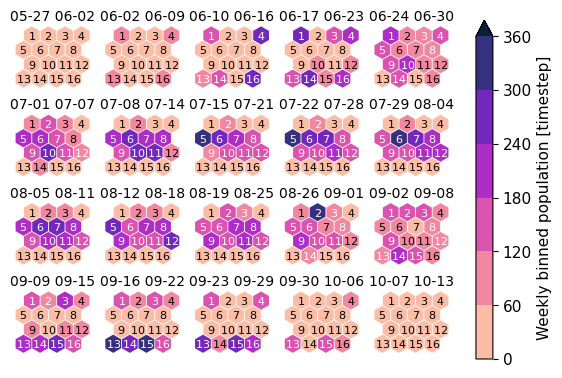

In [5]:
from jetutils.plots import TEXTWIDTH_IN, MaxNLocator, ScalarMappable, ascii_lowercase
fig, axes = plt.subplots(4, 5, figsize=(TEXTWIDTH_IN, 4.4), tight_layout=False, subplot_kw={"aspect": "equal"})
cmap = colormaps.bubblegum_r
max_ = np.quantile([np.amax(timestepwis[1]) for timestepwis in timestepwise], 0.8)
norm = BoundaryNorm(MaxNLocator(6).tick_values(0, max_), cmap.N, extend="max")
im = ScalarMappable(norm, cmap)
coords = net.neighborhoods.coordinates
cbar = fig.colorbar(im, ax=axes)
cbar.ax.set_ylabel("Weekly binned population [timestep]")
for tsw, (i, ax) in zip(timestepwise, enumerate(axes.ravel())):
    step = i + 1
    letter = ascii_lowercase[i]
    unique, counts, start_, end_ = tsw
    to_plot = np.zeros(net.n_nodes)
    to_plot[unique] = counts
    fig, ax = net.plot_on_map(
        to_plot,
        smooth_sigma=0,
        show=False,
        cmap=cmap,
        norm=norm,
        fig=fig,
        ax=ax,
        draw_cbar=False,
        linewidths=0,
    )
    # ax.errorbar(*com[step], *com_std[step][[1, 0]])
    ax.set_title(f"{start_} {end_}", pad=2, fontsize=10)
    
    for i, c in enumerate(coords):
        x, y = c
        color = "white" if to_plot[i] > 100 else "black"
        ax.text(x, y, f'${i + 1}$', va='center', ha='center', color=color, fontsize=8)
fig.set_tight_layout(False)
fig.savefig(f"{FIGURES}/twostep_persistence/seasonal_pathway.png")

## spells

In [5]:
spells = get_persistent_spell_times_from_som(labels, None, 0, 24, nt_before=20, nojune=False, daily=True)
spells = spells.cast({"time": pl.Datetime("ms"), "relative_time": pl.Duration("ms")})

labels_daily = labels.sel(time=labels.time.dt.hour == 0)
mask_daily = labels_to_mask(labels_daily)
jets_daily = all_jets_one_df.filter(pl.col("time").is_in(summer_daily))

spells_per_cluster = spells.filter(pl.col("relative_index") == 0).group_by("value").len()
spells_per_cluster = pl.Series("value", np.arange(net.n_nodes)).to_frame().join(spells_per_cluster, how="left", on="value").fill_null(0)
numbering = [f"{numb + 1}, {spells_per_cluster[int(numb), 'len']}" for numb in range(net.n_nodes)]

props_as_df_anoms = compute_anomalies_pl(props_as_df, ("jet", ), 31, standardize=True)
props_masked = mask_from_spells_pl(spells, props_as_df_anoms, time_before=datetime.timedelta(days=5))
props_masked_ = props_masked.group_by(pl.col("value"), pl.col("relative_index"), pl.col("jet")).mean().rename({"value": "cluster"})
indexer = pl.Series("cluster", np.arange(net.n_nodes)).to_frame().join(props_masked[:, ["jet", "relative_index"]].unique(("jet", "relative_index")), how="cross").sort("cluster", "jet", "relative_index")
props_masked_ = indexer.join(props_masked_, how="left", on=["cluster", "jet", "relative_index"])

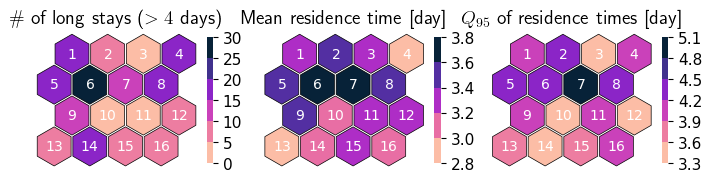

In [6]:
## max len
num_spells_per_cluster = spells.group_by(["value"]).agg(pl.col("spell").n_unique()).sort("value")["spell"].to_numpy()

max_len_per_cluster = spells.group_by(["value", "spell"]).len().group_by("value").agg(pl.col("len").quantile(0.95) / 4)
max_len_per_cluster = pl.Series("value", np.arange(net.n_nodes)).to_frame().join(max_len_per_cluster, how="left", on="value")["len"].to_numpy()

len_per_cluster = spells.group_by("value").len()
len_per_cluster = pl.Series("value", np.arange(net.n_nodes)).to_frame().join(len_per_cluster, how="left", on="value").fill_null(0)
len_per_cluster = len_per_cluster.with_columns(pl.col("len") / spells_per_cluster["len"] / 4)["len"].to_numpy()

cmap = colormaps.bubblegum_r
fig, axes = plt.subplots(1, 3, figsize=(TEXTWIDTH_IN, 2), tight_layout=True, subplot_kw=dict(aspect="equal"))
ouais = zip(
    axes,
    [r"\# of long stays ($> 4$ days)", r"Mean residence time [day]", r"$Q_{95}$ of residence times [day]"],
    [num_spells_per_cluster, len_per_cluster, max_len_per_cluster]
)
for ax, title, stuff in ouais:
    fig, ax = net.plot_on_map(stuff, cmap=cmap, linewidths=0.5, discretify=True, cbar_kwargs={"shrink": 0.8}, fig=fig, ax=ax, numbering=True)
    ax.set_title(title, usetex=True, fontsize=14)
fig.savefig(f"{FIGURES}/twostep_persistence/spells_basics.png")

In [7]:
spells_any = get_persistent_spell_times_from_som(
    labels, None, 0, 1, nt_before=0, nojune=False, daily=False
)
spells_any = spells_any.cast(
    {"time": pl.Datetime("ms"), "relative_time": pl.Duration("ms")}
)

props_masked_short = mask_from_spells_pl(spells_any.filter(pl.col("len") < 12), props_as_df_anoms)
props_masked_short_ = props_masked_short.group_by(pl.col("value"), pl.col("relative_index"), pl.col("jet")).mean().rename({"value": "cluster"})
indexer = pl.Series("cluster", np.arange(net.n_nodes)).to_frame().join(props_masked_short[:, ["jet", "relative_index"]].unique(("jet", "relative_index")), how="cross").sort("cluster", "jet", "relative_index")
props_masked_short_ = indexer.join(props_masked_short_, how="left", on=["cluster", "jet", "relative_index"])
mean_props_short = props_masked_short_.group_by(pl.col(["cluster", "jet"])).mean().sort("cluster", "jet")

props_masked_long = mask_from_spells_pl(spells_any.filter(pl.col("len") > 24), props_as_df_anoms)
props_masked_long_ = props_masked_long.group_by(pl.col("value"), pl.col("relative_index"), pl.col("jet")).mean().rename({"value": "cluster"})
indexer = pl.Series("cluster", np.arange(net.n_nodes)).to_frame().join(props_masked_long[:, ["jet", "relative_index"]].unique(("jet", "relative_index")), how="cross").sort("cluster", "jet", "relative_index")
props_masked_long_ = indexer.join(props_masked_long_, how="left", on=["cluster", "jet", "relative_index"])
mean_props_long = props_masked_long_.group_by(pl.col(["cluster", "jet"])).mean().sort("cluster", "jet")

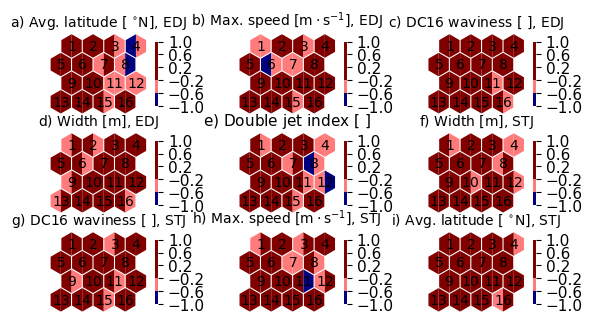

In [ ]:
from string import ascii_lowercase

data_vars_and_jets = [
    ("mean_lat", "EDJ"),
    ("s_star", "EDJ"),
    ("wavinessDC16", "EDJ"),
    ("width", "EDJ"),
    ("double_jet_index", "STJ"),
    ("width", "STJ"),
    ("wavinessDC16", "STJ"),
    ("s_star", "STJ"),
    ("mean_lat", "STJ"),
]

fig, axes = plt.subplots(3, 3, figsize=(TEXTWIDTH_IN, 2.9), gridspec_kw=dict(wspace=0.15, hspace=0.15, bottom=0.00, top=0.98), sharex="all", subplot_kw=dict(aspect="equal"))
axes1 = axes.flatten()
cmap = colormaps.BlWhRe
norm = BoundaryNorm(np.linspace(-1, 1, 6), cmap.N)
for letter, (varname, jet), (j, ax) in zip(ascii_lowercase, data_vars_and_jets, enumerate(axes1)):
    to_plot_1 = mean_props_short.filter(pl.col("jet") == jet)[varname].to_numpy()
    to_plot_2 = mean_props_long.filter(pl.col("jet") == jet)[varname].to_numpy()
    if varname == "double_jet_index":
        ax.set_title(f"{letter}) {PRETTIER_VARNAME[varname]} [{UNITS.get(varname, '')}]", pad=2)
    else:
        ax.set_title(f"{letter}) {PRETTIER_VARNAME[varname]} [{UNITS.get(varname, '')}], {jet}", pad=2, fontsize=10)
    big_feature = np.concatenate([to_plot_1, to_plot_2])
    
    cmap.set_bad(color="powderblue")
    fig, ax = net.plot_on_map(
        to_plot_1,
        to_plot_2,
        smooth_sigma=0,
        show=False,
        fig=fig,
        ax=ax,
        draw_cbar=True,
        cmap=cmap,
        norm=norm,
        linewidths=0,
        cbar_kwargs=dict(shrink=0.75),
        numbering=True,
    )
fig.savefig(f"{FIGURES}/twostep_persistence/jet_props_short_long.png")

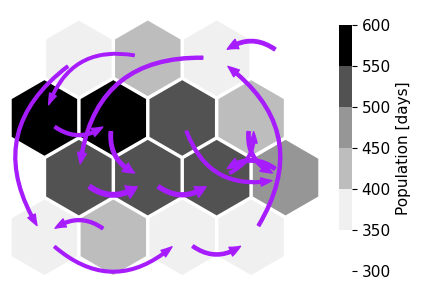

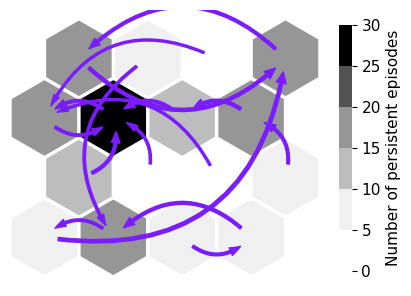

In [9]:
import matplotlib.patches as patches
import polars.selectors as cs
from itertools import product

# What happens before?
spells = get_persistent_spell_times_from_som(
    labels, None, 0, 24, nt_before=1, nojune=False, daily=False
)
spells = spells.cast({"time": pl.Datetime("ms"), "relative_time": pl.Duration("ms")})
spells_any = get_persistent_spell_times_from_som(
    labels, None, 0, 1, nt_before=1, nojune=False, daily=False
)
spells_any = spells_any.cast(
    {"time": pl.Datetime("ms"), "relative_time": pl.Duration("ms")}
)
longest_spell = (
    spells.group_by("value")
    .agg(pl.col("time").filter(pl.col("len") == pl.col("len").max()))
    .explode("time")
    .join(spells, on=["value", "time"])
    .sort("value", "time")
)

labels_masked = spells.join(
    xarray_to_polars(labels).cast({"time": pl.Datetime("ms")}), on="time"
)
labels_any_masked = spells_any.join(
    xarray_to_polars(labels).cast({"time": pl.Datetime("ms")}), on="time"
)
labels_longest_masked = longest_spell.join(
    xarray_to_polars(labels).cast({"time": pl.Datetime("ms")}), on="time"
)
rel_ind = -1
index = pl.int_range(0, 16, eager=True).rename("labels").to_frame()
transitions_any = index.clone()
transitions_spell = index.clone()
transitions_longest = index.clone()

for i in range(16):
    a = labels_any_masked.filter(
        pl.col("value") == i, pl.col("relative_index") == rel_ind
    )["labels"].value_counts(sort=True)
    transitions_any = transitions_any.join(
        a.rename({"count": f"trans to {i}"}), on="labels", how="left"
    )
    a = labels_masked.filter(pl.col("value") == i, pl.col("relative_index") == rel_ind)[
        "labels"
    ].value_counts(sort=True)
    transitions_spell = transitions_spell.join(
        a.rename({"count": f"trans to {i}"}), on="labels", how="left"
    )
    a = labels_longest_masked.filter(
        pl.col("value") == i, pl.col("relative_index") == rel_ind
    )["labels"].value_counts(sort=True)
    transitions_longest = transitions_longest.join(
        a.rename({"count": f"trans to {i}"}), on="labels", how="left"
    )

## spells per cluster

spells_per_cluster = (
    spells.filter(pl.col("relative_index") == 0).group_by("value").len()
)
spells_per_cluster = (
    pl.Series("value", np.arange(net.n_nodes))
    .to_frame()
    .join(spells_per_cluster, how="left", on="value")
    .fill_null(0)
)
cmap = colormaps.greys
transitions_any_ = transitions_any.fill_null(0).with_columns(
    cs.contains("trans") / pl.sum_horizontal(cs.contains("trans"))
)
fig, ax = net.plot_on_map(
    populations / 4,
    cmap=cmap,
    discretify=True,
    cbar_kwargs={"shrink": 0.8, "label": "Population [days]"},
)
for i in range(16):
    to_ = transitions_any_.drop("labels").transpose()[f"column_{i}"].arg_max()
    strength = transitions_any_[i, f"trans to {to_}"]
    tail_width = (strength + 1) ** 4
    head_width = tail_width * 3
    style = f"Simple, tail_width={tail_width:.3f}, head_width={head_width:.3f}, head_length=8"
    kw = dict(
        arrowstyle=style,
        connectionstyle="arc3,rad=.5",
        color=COLORS[0],
        shrinkA=10,
        shrinkB=10,
    )
    ax.add_patch(patches.FancyArrowPatch(coords[i], coords[to_], **kw))
## spells per cluster
fig.savefig(f"{FIGURES}/twostep_persistence/transi_any_maxto.png")

spells_per_cluster = (
    spells.filter(pl.col("relative_index") == 0).group_by("value").len()
)
spells_per_cluster = (
    pl.Series("value", np.arange(net.n_nodes))
    .to_frame()
    .join(spells_per_cluster, how="left", on="value")
    .fill_null(0)
)
cmap = colormaps.greys
transitions_spell_ = transitions_spell.fill_null(0).with_columns(
    cs.contains("trans") / pl.sum_horizontal(cs.contains("trans"))
)
fig, ax = net.plot_on_map(
    spells_per_cluster["len"].to_numpy(),
    cmap=cmap,
    discretify=True,
    cbar_kwargs={"shrink": 0.8, "label": "Number of persistent episodes"},
)
for i in range(16):
    to_ = transitions_spell_.drop("labels").transpose()[f"column_{i}"].arg_max()
    strength = transitions_spell_[i, f"trans to {to_}"]
    tail_width = (strength + 1) ** 2
    head_width = tail_width * 3
    style = f"Simple, tail_width={tail_width:.3f}, head_width={head_width:.3f}, head_length=8"
    kw = dict(
        arrowstyle=style,
        connectionstyle="arc3,rad=.5",
        color=COLORS[1],
        shrinkA=10,
        shrinkB=10,
    )
    ax.add_patch(patches.FancyArrowPatch(coords[i], coords[to_], **kw))
fig.savefig(f"{FIGURES}/twostep_persistence/transi_pe_maxto.png")

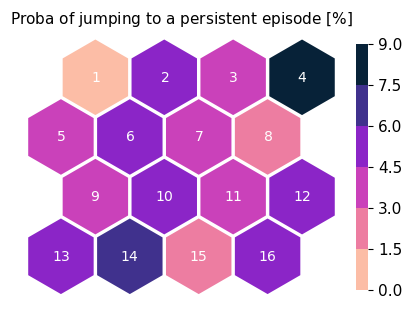

In [10]:
fig, ax = net.plot_on_map((transitions_spell.drop("labels").sum_horizontal() / transitions_any.drop("labels").sum_horizontal()).to_numpy() * 100, discretify=True, cmap=colormaps.bubblegum_r, numbering=True)
ax.set_title(r"Proba of jumping to a persistent episode [$\%$]")
fig.savefig(f"{FIGURES}/twostep_persistence/proba_jump_pe.png")

## Data and such

In [11]:
da_T = open_da(
    "ERA5",
    "surf",
    "t2m",
    "dailymean",
    "all",
    None,
    *get_region(ds),
    "all",
    "dayofyear",
    {"dayofyear": ("win", 15)},
    None,
)
da_T = compute(da_T.sel(time=summer_daily), progress_flag=True)
da_tp = open_da(
    "ERA5",
    "surf",
    "tp",
    "dailysum",
    "all",
    None,
    *get_region(ds),
    "all",
    "dayofyear",
    {"dayofyear": ("win", 15)},
    None,
)
da_tp = compute(da_tp.sel(time=summer_daily), progress_flag=True)
da_apvs = open_da(
    "ERA5",
    "thetalev",
    "apvs",
    "dailyany",
    "all",
    None,
    *get_region(ds),
    "all",
    "dayofyear",
    {"dayofyear": ("win", 15)},
    None,
)
da_apvs = compute(da_apvs.sel(time=summer_daily), progress_flag=True)
da_cpvs = open_da(
    "ERA5",
    "thetalev",
    "cpvs",
    "dailyany",
    "all",
    None,
    *get_region(ds),
    "all",
    "dayofyear",
    {"dayofyear": ("win", 15)},
    None,
)
da_cpvs = compute(da_cpvs.sel(time=summer_daily), progress_flag=True)
long_names = {
    "t_up": "Upper level temperature [K]",
    "t2m": "2m temperature [K]",
    "tp": "Daily accum. precip. [mm]",
    "apvs": r"Anticyclonic PV streamer freq [$\%$]",
    "cpvs": r"Cyclonic PV streamer freq [$\%$]",
}

[########################################] | 100% Completed | 27.41 s
[########################################] | 100% Completed | 25.09 s
[########################################] | 100% Completed | 61.54 s
[########################################] | 100% Completed | 61.26 s


# natural coordinate composites

In [12]:
spells = get_persistent_spell_times_from_som(labels, None, 0, 24, nt_before=20, nojune=False, daily=True)
spells = spells.cast({"time": pl.Datetime("ms"), "relative_time": pl.Duration("ms")})
def symmetrize_p(pvals: xr.DataArray | np.ndarray, direction: int, q: float) -> np.ndarray:
    if direction == 0:
        return np.amin([pvals * 2, (1 - pvals) * 2], axis=0) < q
    if direction == 1:
        return np.asarray(pvals) > 1 - q
    return np.asarray(pvals) < q


def plot_all_relative_composites(jets, times, variable_dict, n_bootstraps: int = 50):
    figs = []
    for varname, props in variable_dict.items():
        if len(props) == 3:
            da, nlevels, cmap = props
            clim = None
        else:
            da, clim, nlevels, cmap = props
        hatch = "xxx" if varname == "tp" else "xx"
        
        jets_during_spells_with_interp_norm_ds = gather_normal_da_jets_wrapper(jets, times, da, n_bootstraps=n_bootstraps, clim=clim)
        try:
            to_plot = jets_during_spells_with_interp_norm_ds[da.name + "_interp"]
            pvals = jets_during_spells_with_interp_norm_ds["pvals"]
        except KeyError:
            to_plot = jets_during_spells_with_interp_norm_ds
            
        direction = infer_direction(to_plot)
        symmetric = direction == 0

        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        levels = MaxNLocator(nlevels, symmetric=symmetric).tick_values(to_plot.quantile(0.01), to_plot.quantile(0.99))
        norm = BoundaryNorm(levels, cmap.N)
        
        axes[0].pcolormesh(to_plot.norm_index, to_plot.n, to_plot[0].T, norm=norm, cmap=cmap)
        filter_ = symmetrize_p(pvals[0].T, direction, 0.05)
        axes[0].pcolor(pvals.norm_index, pvals.n, pvals[0].T.where(filter_), hatch=hatch, alpha=0.)
        
        axes[1].pcolormesh(to_plot.norm_index, to_plot.n, to_plot[1].T, norm=norm, cmap=cmap)
        filter_ = symmetrize_p(pvals[1].T, direction, 0.05)
        axes[1].pcolor(pvals.norm_index, pvals.n, pvals[0].T.where(filter_), hatch=hatch, alpha=0.)

        fig.colorbar(ScalarMappable(norm, cmap), ax=axes, spacing="proportional")
        figs.append(fig)
    return figs

variable_dict = {
    "t2m": [da_T, 8, colormaps.BlWhRe, [-2, 2]],
    "tp": [da_tp * 1000, 13, colormaps.precip4_diff_19lev, [-3, 3]],
    "apvs": [da_apvs * 100, 7, colormaps.curl, [-30, 30]],
    "cpvs": [da_cpvs * 100, 7, colormaps.curl, [-30, 30]],
}
long_names = {
    "t_up": "Upper level temperature [K]",
    "t2m": "2m temperature [K]",
    "tp": "Daily accum. precip. [mm]",
    "apvs": r"Anticyclonic PV streamer freq [$\%$]",
    "cpvs": r"Cyclonic PV streamer freq [$\%$]",
}

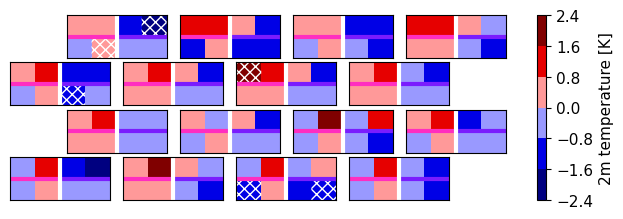

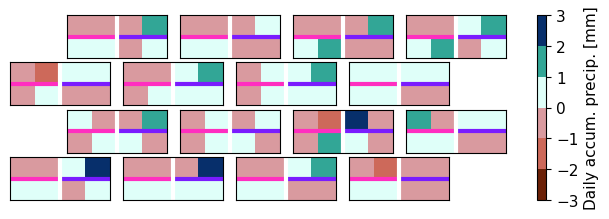

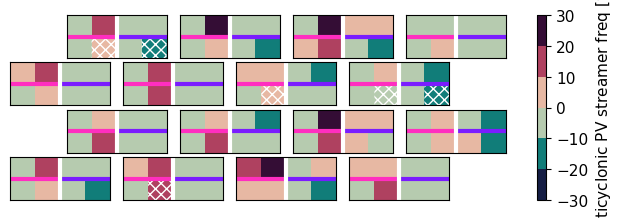

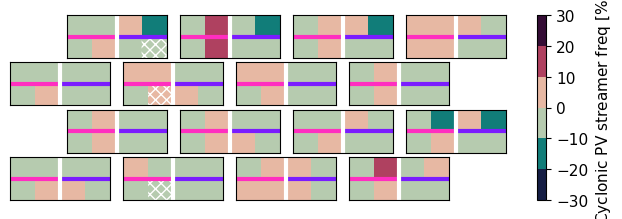

In [17]:
big_to_plot = np.zeros((net.n_nodes, 2, 4))
big_pvals = big_to_plot.copy()
for varname in variable_dict:
    da, nlev, cmap, tick_bounds = variable_dict[varname]
    for i in range(net.n_nodes):
        times = spells.filter(pl.col("value") == i)
        times = subset_around_onset(times, around_onset=datetime.timedelta(days=1))
        jets_during_spells_with_interp_norm_ds = gather_normal_da_jets_wrapper(
            jets_daily.filter(pl.col("time").is_in(summer_daily)), 
            times, da, n_bootstraps=40, n_interp=1, half_length=10, dn=1
        )
        btp = jets_during_spells_with_interp_norm_ds.groupby_bins("n", [-10, 0, 10]).mean()
        big_to_plot[i, :, :] = btp[f"{varname}_interp"].values.reshape(4, 2).T
        big_pvals[i, :, :] = btp["pvals"].values.reshape(4, 2).T
    fig, axes = honeycomb_panel(4, 4, ratio=0.3, row_height=2, hspace=0.1, wspace=0.3)
    axes = axes.ravel()
    norm = BoundaryNorm(MaxNLocator(6, symmetric=True).tick_values(*tick_bounds), cmap.N)
    none_map = ListedColormap(['none'])
    for i, ax in enumerate(axes):
        ax.set_xticks([])
        ax.set_yticks([])
        ax.pcolormesh([0, 0.5, 1.0, 1.5, 2], [-1, 0, 1], big_to_plot[i], cmap=cmap, norm=norm)
        filter_ = symmetrize_p(big_pvals[i], 0, 0.05)
        big_pvals[i][~filter_] = np.nan
        ax.pcolor([0, 0.5, 1.0, 1.5, 2], [-1, 0, 1], big_pvals[i], hatch="xxx", cmap=none_map, edgecolor='white', lw=0, zorder=2)
        ax.plot([0, 1], [0, 0], color=COLORS[2], lw=3)
        ax.plot([1., 2], [0, 0], color=COLORS[1], lw=3)
        ax.plot([1, 1], [-1, 1], color="white", lw=3)
    cbar = fig.colorbar(ScalarMappable(norm, cmap), ax=axes, label=long_names[varname])
    fig.savefig(f"{FIGURES}/twostep_persistence/{varname}_around_jet.png")

# masked jets props

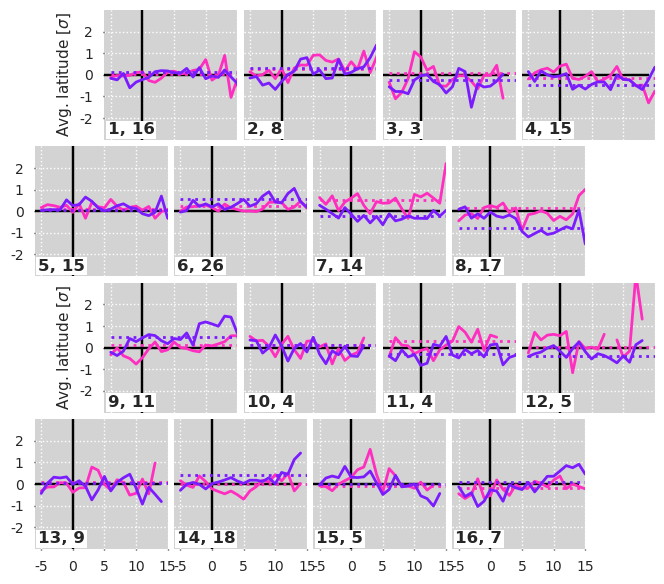

In [102]:
plt.style.use('seaborn-v0_8')
fig, axes = honeycomb_panel(
    4, 4, .4, hspace=0.05, wspace=0.1,
)
fig.set_size_inches(8, 7)
rel_ind_ticks = [-5, 0, 5, 10, 15]
anom_ticks = [-2, -1, 0, 1, 2]
varname = "mean_lat"
mean_anoms = {}
for jet in ["STJ", "EDJ"]:
    to_plot = props_as_df_anoms.filter(pl.col("time").cast(pl.Datetime("us")).is_in(labels["time"].values.astype('datetime64[ms]').tolist()), pl.col("jet") == jet)[varname].to_numpy()
    mean_anoms[jet] = timeseries_on_map(to_plot, net.latest_bmus)[0]
for (l, ax), (i, j), number in zip(enumerate(axes.ravel()), zip(*np.unravel_index(np.arange(axes.size), axes.shape)), numbering):
    ax.spines[["top", "bottom"]].set_visible(False)
    ax.vlines(0, -3, 3, color="black")
    ax.hlines(0, -6, 14, color="black")
    for k, jet in enumerate(["STJ", "EDJ"]):
        to_plot_ = props_masked_.filter(pl.col("jet") == jet, pl.col("cluster") == l)
        ax.plot(to_plot_["relative_index"], to_plot_[varname], color=COLORS[2 - k], lw=2)
        ax.plot([rel_ind_ticks[0], rel_ind_ticks[-1]], [mean_anoms[jet][l], mean_anoms[jet][l]], color=COLORS[2 - k], lw=2, linestyle="dotted")
    ax.grid(linestyle="dotted")
    ax.set_xlim([-6, 14])
    ax.set_ylim([-3, 3])
    ax.set_facecolor('lightgray')
    if i == 3:
        ax.set_xticks(rel_ind_ticks, labels=rel_ind_ticks)
        ax.tick_params(axis='x', width=1, size=1)
    else:
        ax.set_xticks(rel_ind_ticks, labels=[])
        ax.tick_params(axis='x', width=0, size=0)
    if j == 0:
        ax.set_yticks(anom_ticks, labels=anom_ticks)
        ax.tick_params(axis='y', width=1, size=1)
        if i in [0, 2]:
            ax.set_ylabel(fr"{PRETTIER_VARNAME[varname]} [$\sigma$]")
    else:       
        ax.set_yticks(anom_ticks, labels=[])
        ax.tick_params(axis='y', width=0, size=0)
    ax.annotate(
        number,
        (2.2, 4),
        xycoords="axes points",
        ha="left",
        va="baseline",
        fontweight="demi",
        fontsize=12,
        bbox={
            "boxstyle": "square, pad=0.1",
            "edgecolor": "none",
            "facecolor": "white",
        },
        usetex=False,
    )
fig.savefig(f"{FIGURES}/twostep_persistence/jet_props_{varname}.png")

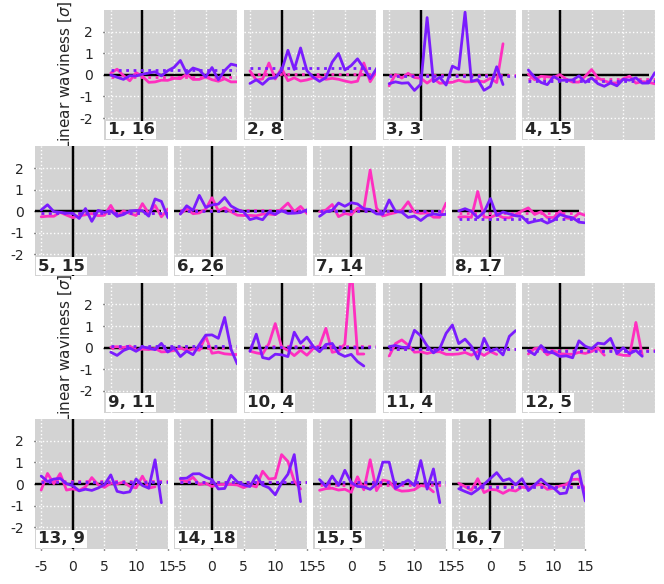

In [103]:
plt.style.use('seaborn-v0_8')
fig, axes = honeycomb_panel(
    4, 4, .4, hspace=0.05, wspace=0.1,
)
fig.set_size_inches(8, 7)
rel_ind_ticks = [-5, 0, 5, 10, 15]
anom_ticks = [-2, -1, 0, 1, 2]
varname = "waviness1"
mean_anoms = {}
for jet in ["STJ", "EDJ"]:
    to_plot = props_as_df_anoms.filter(pl.col("time").cast(pl.Datetime("us")).is_in(labels["time"].values.astype('datetime64[ms]').tolist()), pl.col("jet") == jet)[varname].to_numpy()
    mean_anoms[jet] = timeseries_on_map(to_plot, net.latest_bmus)[0]
for (l, ax), (i, j), number in zip(enumerate(axes.ravel()), zip(*np.unravel_index(np.arange(axes.size), axes.shape)), numbering):
    ax.spines[["top", "bottom"]].set_visible(False)
    ax.vlines(0, -3, 3, color="black")
    ax.hlines(0, -6, 14, color="black")
    for k, jet in enumerate(["STJ", "EDJ"]):
        to_plot_ = props_masked_.filter(pl.col("jet") == jet, pl.col("cluster") == l)
        ax.plot(to_plot_["relative_index"], to_plot_[varname], color=COLORS[2 - k], lw=2)
        ax.plot([rel_ind_ticks[0], rel_ind_ticks[-1]], [mean_anoms[jet][l], mean_anoms[jet][l]], color=COLORS[2 - k], lw=2, linestyle="dotted")
    ax.grid(linestyle="dotted")
    ax.set_xlim([-6, 14])
    ax.set_ylim([-3, 3])
    ax.set_facecolor('lightgray')
    if i == 3:
        ax.set_xticks(rel_ind_ticks, labels=rel_ind_ticks)
        ax.tick_params(axis='x', width=1, size=1)
    else:
        ax.set_xticks(rel_ind_ticks, labels=[])
        ax.tick_params(axis='x', width=0, size=0)
    if j == 0:
        ax.set_yticks(anom_ticks, labels=anom_ticks)
        ax.tick_params(axis='y', width=1, size=1)
        if i in [0, 2]:
            ax.set_ylabel(fr"{PRETTIER_VARNAME[varname]} [$\sigma$]")
    else:       
        ax.set_yticks(anom_ticks, labels=[])
        ax.tick_params(axis='y', width=0, size=0)
    ax.annotate(
        number,
        (2.2, 4),
        xycoords="axes points",
        ha="left",
        va="baseline",
        fontweight="demi",
        fontsize=12,
        bbox={
            "boxstyle": "square, pad=0.1",
            "edgecolor": "none",
            "facecolor": "white",
        },
        usetex=False,
    )
fig.savefig(f"{FIGURES}/twostep_persistence/jet_props_{varname}.png")

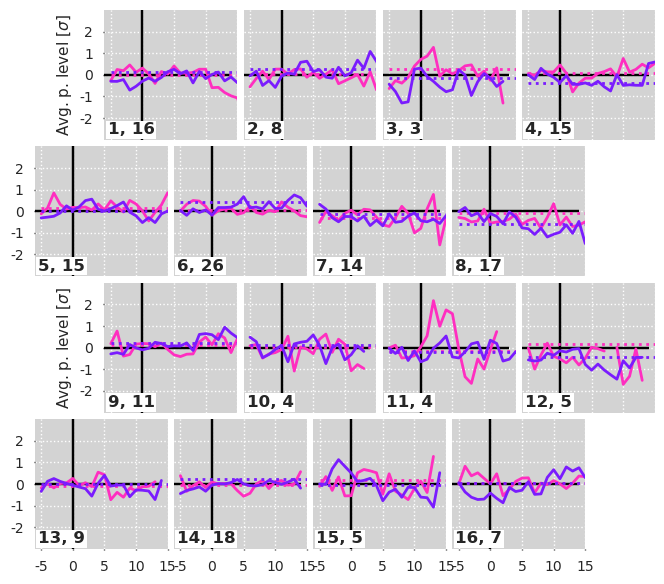

In [104]:
plt.style.use('seaborn-v0_8')
fig, axes = honeycomb_panel(
    4, 4, .4, hspace=0.05, wspace=0.1,
)
fig.set_size_inches(8, 7)
rel_ind_ticks = [-5, 0, 5, 10, 15]
anom_ticks = [-2, -1, 0, 1, 2]
varname = "mean_lev"
mean_anoms = {}
for jet in ["STJ", "EDJ"]:
    to_plot = props_as_df_anoms.filter(pl.col("time").cast(pl.Datetime("us")).is_in(labels["time"].values.astype('datetime64[ms]').tolist()), pl.col("jet") == jet)[varname].to_numpy()
    mean_anoms[jet] = timeseries_on_map(to_plot, net.latest_bmus)[0]
for (l, ax), (i, j), number in zip(enumerate(axes.ravel()), zip(*np.unravel_index(np.arange(axes.size), axes.shape)), numbering):
    ax.spines[["top", "bottom"]].set_visible(False)
    ax.vlines(0, -3, 3, color="black")
    ax.hlines(0, -6, 14, color="black")
    for k, jet in enumerate(["STJ", "EDJ"]):
        to_plot_ = props_masked_.filter(pl.col("jet") == jet, pl.col("cluster") == l)
        ax.plot(to_plot_["relative_index"], to_plot_[varname], color=COLORS[2 - k], lw=2)
        ax.plot([rel_ind_ticks[0], rel_ind_ticks[-1]], [mean_anoms[jet][l], mean_anoms[jet][l]], color=COLORS[2 - k], lw=2, linestyle="dotted")
    ax.grid(linestyle="dotted")
    ax.set_xlim([-6, 14])
    ax.set_ylim([-3, 3])
    ax.set_facecolor('lightgray')
    if i == 3:
        ax.set_xticks(rel_ind_ticks, labels=rel_ind_ticks)
        ax.tick_params(axis='x', width=1, size=1)
    else:
        ax.set_xticks(rel_ind_ticks, labels=[])
        ax.tick_params(axis='x', width=0, size=0)
    if j == 0:
        ax.set_yticks(anom_ticks, labels=anom_ticks)
        ax.tick_params(axis='y', width=1, size=1)
        if i in [0, 2]:
            ax.set_ylabel(fr"{PRETTIER_VARNAME[varname]} [$\sigma$]")
    else:       
        ax.set_yticks(anom_ticks, labels=[])
        ax.tick_params(axis='y', width=0, size=0)
    ax.annotate(
        number,
        (2.2, 4),
        xycoords="axes points",
        ha="left",
        va="baseline",
        fontweight="demi",
        fontsize=12,
        bbox={
            "boxstyle": "square, pad=0.1",
            "edgecolor": "none",
            "facecolor": "white",
        },
        usetex=False,
    )
fig.savefig(f"{FIGURES}/twostep_persistence/jet_props_{varname}.png")

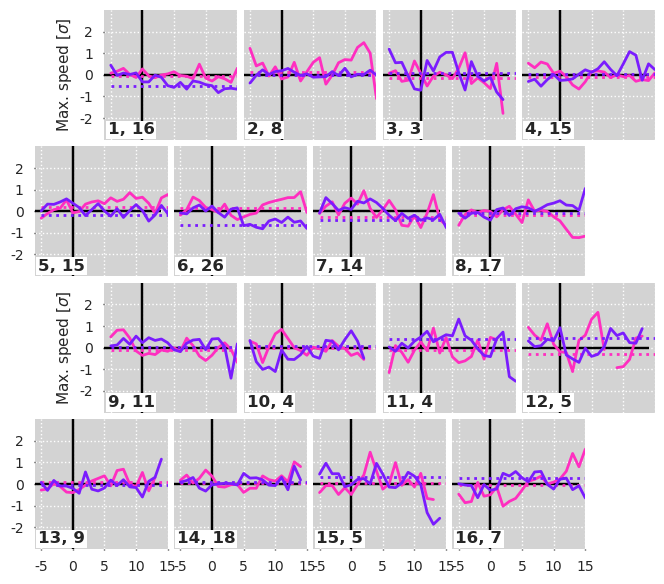

In [105]:
plt.style.use('seaborn-v0_8')
fig, axes = honeycomb_panel(
    4, 4, .4, hspace=0.05, wspace=0.1,
)
fig.set_size_inches(8, 7)
rel_ind_ticks = [-5, 0, 5, 10, 15]
anom_ticks = [-2, -1, 0, 1, 2]
varname = "s_star"
mean_anoms = {}
for jet in ["STJ", "EDJ"]:
    to_plot = props_as_df_anoms.filter(pl.col("time").cast(pl.Datetime("us")).is_in(labels["time"].values.astype('datetime64[ms]').tolist()), pl.col("jet") == jet)[varname].to_numpy()
    mean_anoms[jet] = timeseries_on_map(to_plot, net.latest_bmus)[0]
for (l, ax), (i, j), number in zip(enumerate(axes.ravel()), zip(*np.unravel_index(np.arange(axes.size), axes.shape)), numbering):
    ax.spines[["top", "bottom"]].set_visible(False)
    ax.vlines(0, -3, 3, color="black")
    ax.hlines(0, -6, 14, color="black")
    for k, jet in enumerate(["STJ", "EDJ"]):
        to_plot_ = props_masked_.filter(pl.col("jet") == jet, pl.col("cluster") == l)
        ax.plot(to_plot_["relative_index"], to_plot_[varname], color=COLORS[2 - k], lw=2)
        ax.plot([rel_ind_ticks[0], rel_ind_ticks[-1]], [mean_anoms[jet][l], mean_anoms[jet][l]], color=COLORS[2 - k], lw=2, linestyle="dotted")
    ax.grid(linestyle="dotted")
    ax.set_xlim([-6, 14])
    ax.set_ylim([-3, 3])
    ax.set_facecolor('lightgray')
    if i == 3:
        ax.set_xticks(rel_ind_ticks, labels=rel_ind_ticks)
        ax.tick_params(axis='x', width=1, size=1)
    else:
        ax.set_xticks(rel_ind_ticks, labels=[])
        ax.tick_params(axis='x', width=0, size=0)
    if j == 0:
        ax.set_yticks(anom_ticks, labels=anom_ticks)
        ax.tick_params(axis='y', width=1, size=1)
        if i in [0, 2]:
            ax.set_ylabel(fr"{PRETTIER_VARNAME[varname]} [$\sigma$]")
    else:       
        ax.set_yticks(anom_ticks, labels=[])
        ax.tick_params(axis='y', width=0, size=0)
    ax.annotate(
        number,
        (2.2, 4),
        xycoords="axes points",
        ha="left",
        va="baseline",
        fontweight="demi",
        fontsize=12,
        bbox={
            "boxstyle": "square, pad=0.1",
            "edgecolor": "none",
            "facecolor": "white",
        },
        usetex=False,
    )
fig.savefig(f"{FIGURES}/twostep_persistence/jet_props_{varname}.png")

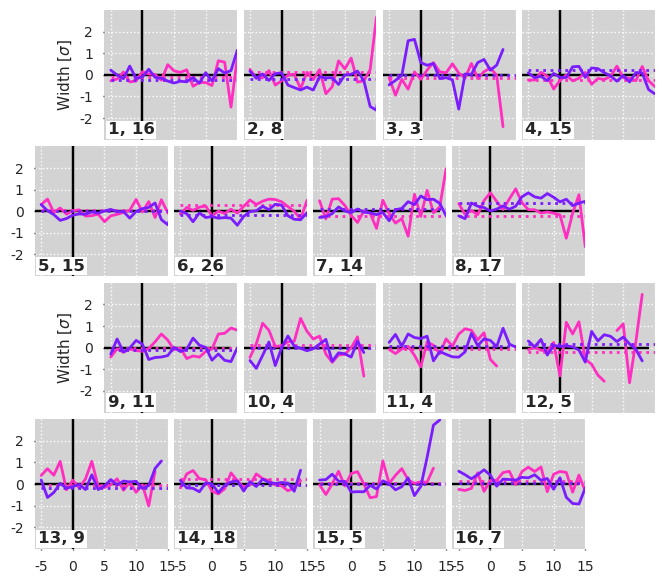

In [106]:
plt.style.use('seaborn-v0_8')
fig, axes = honeycomb_panel(
    4, 4, .4, hspace=0.05, wspace=0.1,
)
fig.set_size_inches(8, 7)
rel_ind_ticks = [-5, 0, 5, 10, 15]
anom_ticks = [-2, -1, 0, 1, 2]
varname = "width"
mean_anoms = {}
for jet in ["STJ", "EDJ"]:
    to_plot = props_as_df_anoms.filter(pl.col("time").cast(pl.Datetime("us")).is_in(labels["time"].values.astype('datetime64[ms]').tolist()), pl.col("jet") == jet)[varname].to_numpy()
    mean_anoms[jet] = timeseries_on_map(to_plot, net.latest_bmus)[0]
for (l, ax), (i, j), number in zip(enumerate(axes.ravel()), zip(*np.unravel_index(np.arange(axes.size), axes.shape)), numbering):
    ax.spines[["top", "bottom"]].set_visible(False)
    ax.vlines(0, -3, 3, color="black")
    ax.hlines(0, -6, 14, color="black")
    for k, jet in enumerate(["STJ", "EDJ"]):
        to_plot_ = props_masked_.filter(pl.col("jet") == jet, pl.col("cluster") == l)
        ax.plot(to_plot_["relative_index"], to_plot_[varname], color=COLORS[2 - k], lw=2)
        ax.plot([rel_ind_ticks[0], rel_ind_ticks[-1]], [mean_anoms[jet][l], mean_anoms[jet][l]], color=COLORS[2 - k], lw=2, linestyle="dotted")
    ax.grid(linestyle="dotted")
    ax.set_xlim([-6, 14])
    ax.set_ylim([-3, 3])
    ax.set_facecolor('lightgray')
    if i == 3:
        ax.set_xticks(rel_ind_ticks, labels=rel_ind_ticks)
        ax.tick_params(axis='x', width=1, size=1)
    else:
        ax.set_xticks(rel_ind_ticks, labels=[])
        ax.tick_params(axis='x', width=0, size=0)
    if j == 0:
        ax.set_yticks(anom_ticks, labels=anom_ticks)
        ax.tick_params(axis='y', width=1, size=1)
        if i in [0, 2]:
            ax.set_ylabel(fr"{PRETTIER_VARNAME[varname]} [$\sigma$]")
    else:       
        ax.set_yticks(anom_ticks, labels=[])
        ax.tick_params(axis='y', width=0, size=0)
    ax.annotate(
        number,
        (2.2, 4),
        xycoords="axes points",
        ha="left",
        va="baseline",
        fontweight="demi",
        fontsize=12,
        bbox={
            "boxstyle": "square, pad=0.1",
            "edgecolor": "none",
            "facecolor": "white",
        },
        usetex=False,
    )
fig.savefig(f"{FIGURES}/twostep_persistence/jet_props_{varname}.png")

# composites

## wind, jets

In [13]:
ds_summer = ds.sel(time=summer_daily.to_numpy())
ds_summer = compute(ds_summer, progress_flag=True)

In [14]:
uvs_masked = mask_from_spells_pl(spells, ds_summer)

In [15]:
uvs_masked_per_cluster = uvs_masked.groupby("value").mean("spell").rename({"value": "cluster"})
u_clu = uvs_masked_per_cluster.cluster.values.astype(np.int32)
to_zero = np.arange(net.n_nodes)[~np.isin(np.arange(net.n_nodes), u_clu)]
indexer = np.repeat(u_clu, np.diff(np.append(u_clu, [net.n_nodes])))
uvs_masked_per_cluster = uvs_masked_per_cluster.sel(cluster=indexer)
uvs_masked_per_cluster = uvs_masked_per_cluster.assign_coords(cluster=np.arange(net.n_nodes))
uvs_masked_per_cluster.loc[{"cluster": to_zero}] = 0.

In [16]:
uvs_masked_per_cluster

<xarray.Dataset> Size: 679MB
Dimensions:         (cluster: 16, relative_index: 21, lat: 131, lon: 241)
Coordinates:
    relative_time   (relative_index) timedelta64[ns] 168B 0 days ... 20 days
  * relative_index  (relative_index) int32 84B 0 1 2 3 4 5 ... 15 16 17 18 19 20
  * lat             (lat) float32 524B 15.0 15.5 16.0 16.5 ... 79.0 79.5 80.0
  * lon             (lon) float32 964B -80.0 -79.5 -79.0 ... 39.0 39.5 40.0
  * cluster         (cluster) int64 128B 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
Data variables:
    year            (cluster, relative_index, lat, lon) float64 85MB 1.996e+0...
    my_len          (cluster, relative_index, lat, lon) float64 85MB 1.632e+0...
    rel_start       (cluster, relative_index, lat, lon) float64 85MB 175.9 .....
    start           (cluster, relative_index, lat, lon) float64 85MB 1.649e+0...
    range           (cluster, relative_index, lat, lon) float64 85MB 1.648e+0...
    s               (cluster, relative_index, lat, lon) float32 42MB 12.6 ......
    lev             (cluster, relative_index, lat, lon) float32 42MB 191.1 .....
    u               (cluster, relative_index, lat, lon) float32 42MB 3.951 .....
    v               (cluster, relative_index, lat, lon) float32 42MB -4.379 ....
    theta           (cluster, relative_index, lat, lon) float64 85MB 347.9 .....

In [17]:
jets_masked = find_all_jets(uvs_masked_per_cluster.reset_coords("relative_time"), base_s_thresh=0.75)

100%|██████████| 336/336 [00:01<00:00, 232.53it/s]


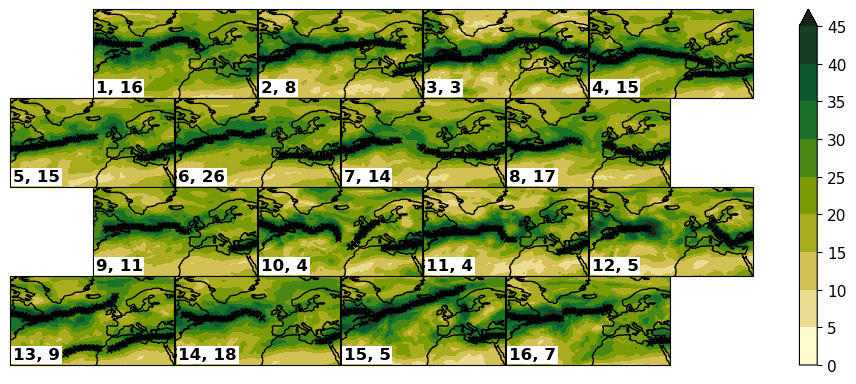

In [18]:
clu = Clusterplot(4, 4, honeycomb=True, region=get_region(uvs_masked_per_cluster), numbering=numbering)
_ = clu.add_contourf(uvs_masked_per_cluster["s"].sel(relative_index=0), cmap=colormaps.speed, levels=9, q=1-1e-2)
axes = clu.axes.ravel()
for i in range(net.n_nodes):
    jets = jets_masked.filter(pl.col("cluster") == i, pl.col("relative_index") == 0)
    for j, jet in jets.group_by("jet ID", maintain_order=True):
        lo, la = jet[["lon", "lat"]].to_numpy().T
        axes[i].scatter(lo, la, lw=1, s=15, c="black", marker="x")
clu.fig.savefig(f"{FIGURES}/twostep_persistence/wind_at_onset.png")
# for i in range(net.n_nodes):
#     jets = all_jets_center_summer.filter(pl.col("cluster") == i)
#     for j, jet in jets.group_by("jet ID", maintain_order=True):
#         lo, la, is_p = jet[["lon", "lat", "is_polar"]].to_numpy().T
#         axes[i].scatter(lo, la, color="gray", lw=1, s=15, marker="+")

## temp

In [19]:
da_T = compute(da_T.sel(time=summer_daily.to_numpy()), progress_flag=True)

100%|██████████| 16/16 [00:00<00:00, 514.71it/s]


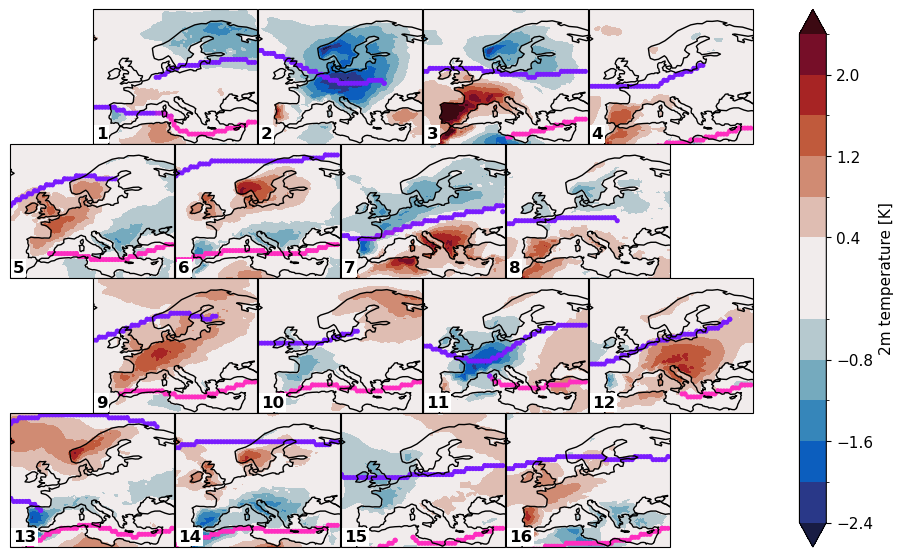

In [158]:
da_T_europe = extract(da_T, "all", None, -15, 40, 30, 75)
clu = Clusterplot(4, 4, honeycomb=True, region=get_region(da_T_europe), numbering=True)
_ = clu.add_any_contour_from_mask(da_T_europe, mask_daily, cmap=colormaps.balance, levels=12, q=1-1e-3, cbar_label=long_names["t2m"])
axes = clu.axes.ravel()
for i in range(net.n_nodes):
    jets = all_jets_center_summer.filter(pl.col("cluster") == i)
    for j, jet in jets.group_by("jet ID", maintain_order=True):
        lo, la, is_p = jet[["lon", "lat", "is_polar"]].to_numpy().T
        axes[i].scatter(lo, la, c=is_p, lw=1, s=7, cmap=PINKPURPLE, vmin=0, vmax=1)
clu.fig.savefig(f"{FIGURES}/twostep_persistence/t2m_europe.png")


In [56]:
from pathlib import Path
from jetutils.anyspell import regionalize
T_masked = mask_from_spells_pl(spells, da_T_europe)["t2m"]
clusters_da = np.abs(xr.open_dataarray(Path(DATADIR, "ERA5/heatwaves_duncan/cluster_df.nc")).load())
clusters_da = clusters_da.interp(lat=np.arange(32, 72, 0.5), method="nearest")
region_ts_masked = regionalize(T_masked, clusters_da, None)
region_ts_masked = region_ts_masked.cast({"len": pl.UInt16(), "value": pl.UInt16()})

In [102]:
to_plot = region_ts_masked[["value"]].unique().drop_nulls().join(region_ts_masked[["region"]].unique().drop_nulls(), how="cross").sort("region", "value").join(region_ts_masked.filter(pl.col("relative_index") == 0).group_by(["value", "region"]).agg(pl.col("t2m").mean()), on=["region", "value"], how="left")
to_plot_np = to_plot["t2m"].to_numpy().reshape(6, -1)

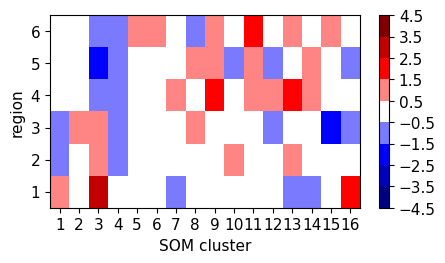

In [109]:
fig, ax = plt.subplots(figsize=(5, 2.5))
cmap = colormaps.BlWhRe
im = ax.pcolormesh(to_plot_np, cmap=cmap, norm=BoundaryNorm(np.arange(-4.5, 5), cmap.N))
ax.set_xticks(np.arange(16) + 0.5, labels=np.arange(1, 17))
ax.set_xlabel("SOM cluster")
ax.set_yticks(np.arange(6) + 0.5, labels=np.arange(1, 7))
ax.set_ylabel("region")
fig.colorbar(im, ax=ax)

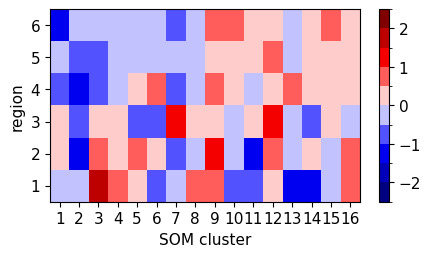

In [122]:
region_ts = regionalize(da_T_europe, clusters_da, None)
region_ts = region_ts.join(xarray_to_polars(labels_daily).cast({"time": pl.Datetime("ms")}), on="time")
to_plot = region_ts.group_by(["region", "labels"]).agg(pl.col("t2m").mean()).sort(["region", "labels"])
to_plot_np = to_plot["t2m"].to_numpy().reshape(6, -1)
fig, ax = plt.subplots(figsize=(5, 2.5))
cmap = colormaps.BlWhRe
im = ax.pcolormesh(to_plot_np, cmap=cmap, norm=BoundaryNorm(np.arange(-2.5, 3, 0.5), cmap.N))
ax.set_xticks(np.arange(16) + 0.5, labels=np.arange(1, 17))
ax.set_xlabel("SOM cluster")
ax.set_yticks(np.arange(6) + 0.5, labels=np.arange(1, 7))
ax.set_ylabel("region")
fig.colorbar(im, ax=ax)

In [69]:
def func(da):
    return da[da["len"].argmax()]
T_longest = T_masked[:, 0, :, :].groupby("value").map(func)

In [63]:
T_masked_per_cluster = T_masked.groupby("value").reduce(np.mean, "spell").rename({"value": "cluster"})
u_clu = T_masked_per_cluster.cluster.values.astype(np.int32)
to_zero = np.arange(net.n_nodes)[~np.isin(np.arange(net.n_nodes), u_clu)]
indexer = np.repeat(u_clu, np.diff(np.append(u_clu, [net.n_nodes])))
T_masked_per_cluster = T_masked_per_cluster.sel(cluster=indexer)
T_masked_per_cluster[to_zero, ...] = 0.
T_masked_per_cluster = T_masked_per_cluster.assign_coords(cluster=np.arange(net.n_nodes))

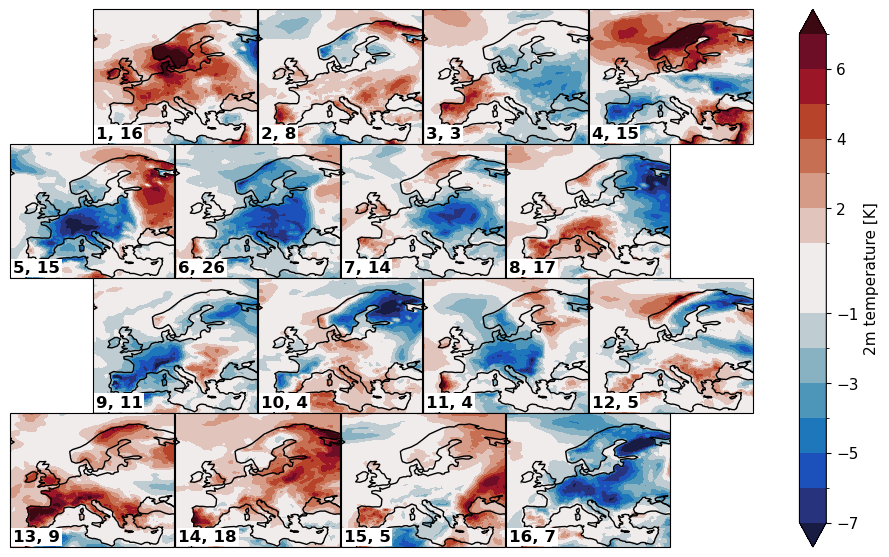

In [159]:
clu = Clusterplot(4, 4, honeycomb=True, region=get_region(T_longest), numbering=numbering)
_ = clu.add_contourf(T_longest, cmap=colormaps.balance, levels=13, q=1-1e-2, cbar_label=long_names["t2m"])
axes = clu.axes.ravel()
clu.fig.savefig(f"{FIGURES}/twostep_persistence/t2m_onset_longest.png")

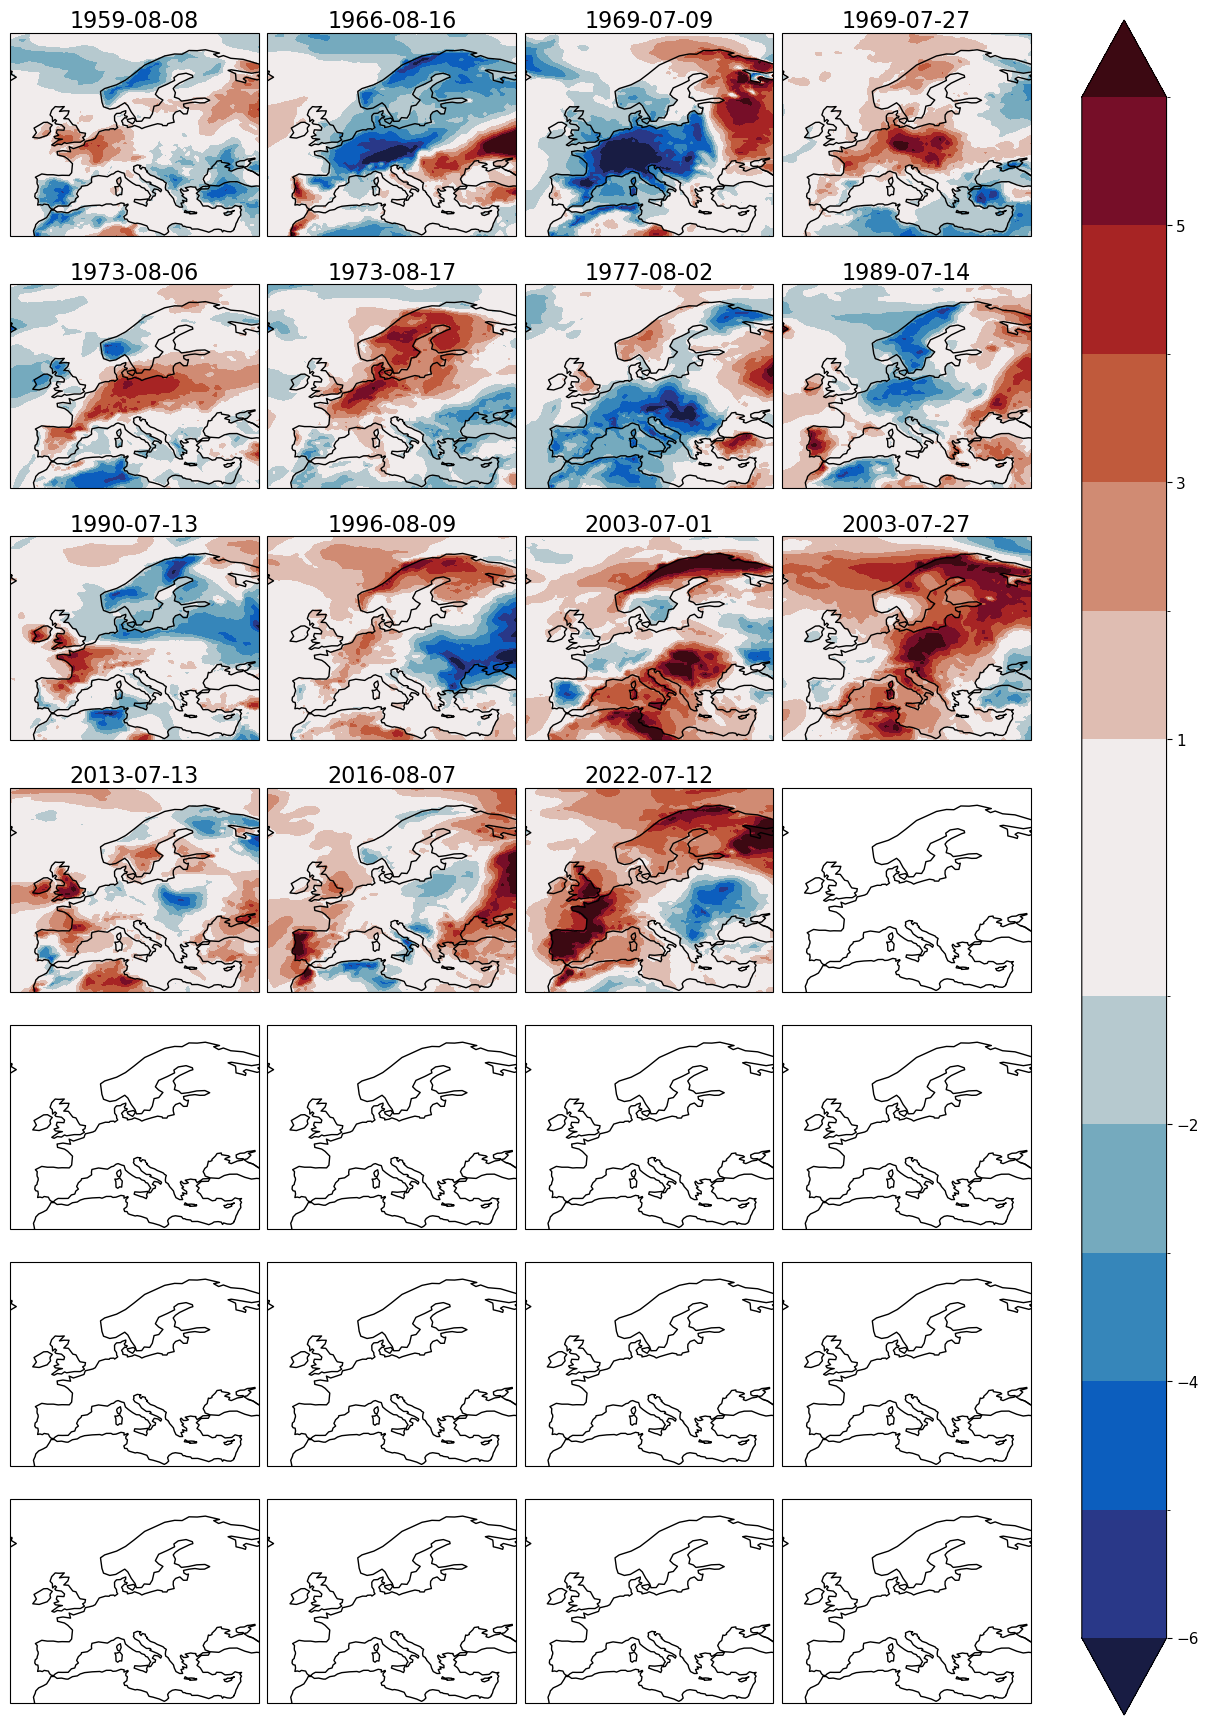

In [96]:
to_plot = T_masked.sel(spell=T_masked.value == 4)
clu = Clusterplot(7, 4, honeycomb=False, region=get_region(T_masked_per_cluster))
_ = clu.add_contourf(to_plot.sel(relative_index=0), cmap=colormaps.balance, levels=13, q=1-1e-2, titles=to_plot.sel(relative_index=0)["time"].to_numpy().astype("datetime64[D]"))

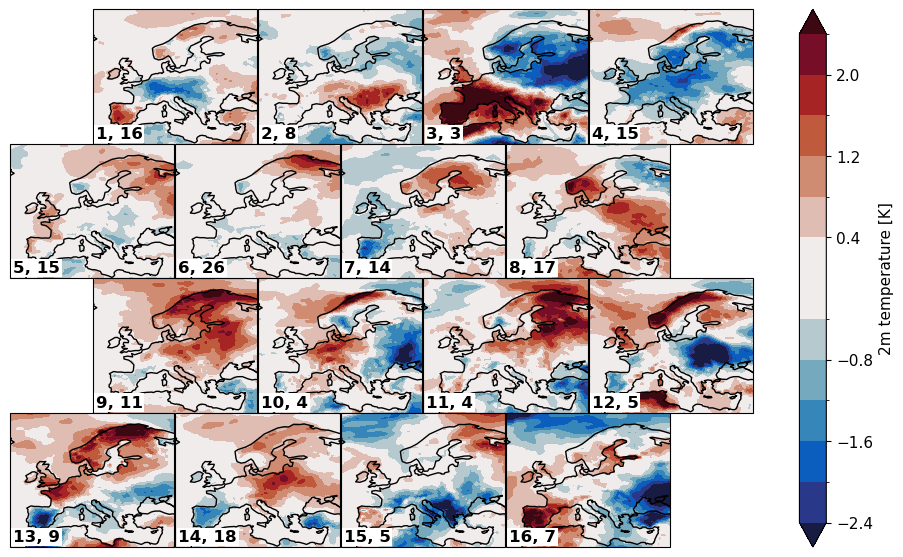

In [160]:
clu = Clusterplot(4, 4, honeycomb=True, region=get_region(T_masked_per_cluster), numbering=numbering)
_ = clu.add_contourf(T_masked_per_cluster.sel(relative_index=0), cmap=colormaps.balance, levels=13, q=1-1e-2, cbar_label=long_names["t2m"])
for i in range(net.n_nodes):
    jets = jets_masked.filter(pl.col("cluster") == i, pl.col("relative_index") == 0)
    for j, jet in jets.group_by("jet ID", maintain_order=True):
        lo, la = jet[["lon", "lat"]].to_numpy().T
        axes[i].scatter(lo, la, lw=1, s=15, c="black", marker="x")
for i in range(net.n_nodes):
    jets = all_jets_center_summer.filter(pl.col("cluster") == i)
    for j, jet in jets.group_by("jet ID", maintain_order=True):
        lo, la, is_p = jet[["lon", "lat", "is_polar"]].to_numpy().T
        axes[i].scatter(lo, la, color="gray", lw=1, s=15, marker="+")
clu.fig.savefig(f"{FIGURES}/twostep_persistence/t2m_onset.png")

## precip

100%|██████████| 16/16 [00:00<00:00, 82.11it/s]


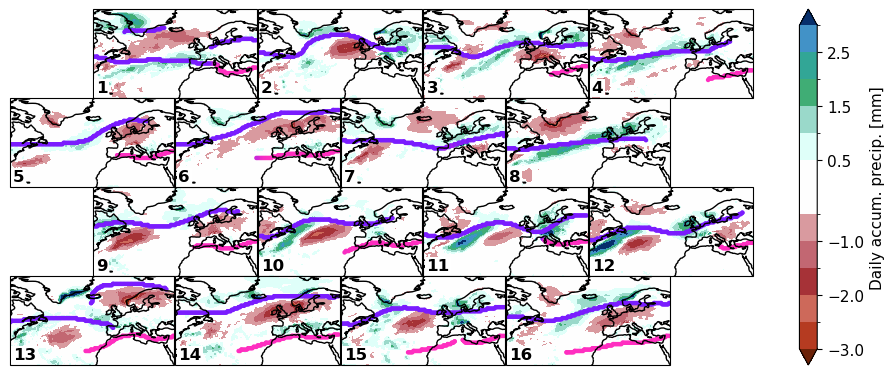

In [161]:
clu = Clusterplot(4, 4, honeycomb=True, region=get_region(da_tp), numbering=True)
_ = clu.add_any_contour_from_mask(da_tp * 1000, mask_daily, cmap=colormaps.precip4_diff_19lev, levels=12, q=1-1e-3, cbar_label=long_names["tp"])
axes = clu.axes.ravel()
for i in range(net.n_nodes):
    jets = all_jets_center_summer.filter(pl.col("cluster") == i)
    for j, jet in jets.group_by("jet ID", maintain_order=True):
        lo, la, is_p = jet[["lon", "lat", "is_polar"]].to_numpy().T
        axes[i].scatter(lo, la, c=is_p, lw=1, s=5, cmap=PINKPURPLE, vmin=0, vmax=1)
clu.fig.savefig(f"{FIGURES}/twostep_persistence/tp.png")

In [75]:
tp_masked = mask_from_spells_pl(spells, da_tp)["tp"]

In [76]:
tp_masked= tp_masked["tp"]

In [77]:
tp_masked_per_cluster = tp_masked.groupby("value").mean("spell").rename({"value": "cluster"})
u_clu = tp_masked_per_cluster.cluster.values.astype(np.int32)
to_zero = np.arange(net.n_nodes)[~np.isin(np.arange(net.n_nodes), u_clu)]
indexer = np.repeat(u_clu, np.diff(np.append(u_clu, [net.n_nodes])))
tp_masked_per_cluster = tp_masked_per_cluster.sel(cluster=indexer)
tp_masked_per_cluster[to_zero, ...] = 0.
tp_masked_per_cluster = tp_masked_per_cluster.assign_coords(cluster=np.arange(net.n_nodes))

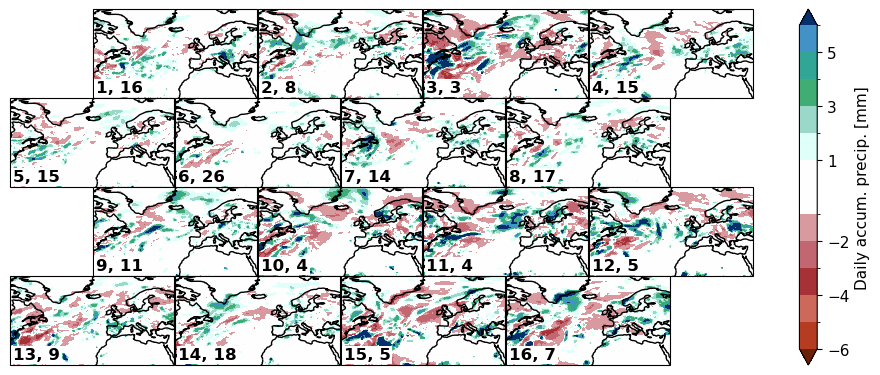

In [162]:
clu = Clusterplot(4, 4, honeycomb=True, region=get_region(tp_masked_per_cluster), numbering=numbering)
_ = clu.add_contourf(tp_masked_per_cluster.sel(relative_index=0) * 1000, cmap=colormaps.precip4_diff_19lev, levels=13, q=1-1e-2, cbar_label=long_names["tp"])
clu.fig.savefig(f"{FIGURES}/twostep_persistence/tp_onset.png")

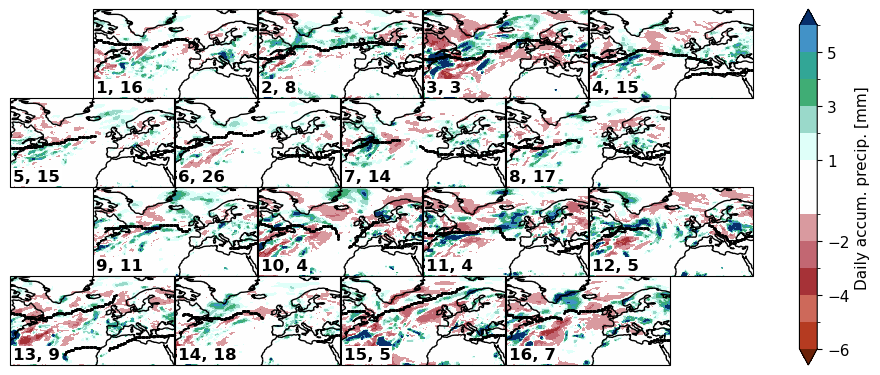

In [163]:
clu = Clusterplot(4, 4, honeycomb=True, region=get_region(tp_masked_per_cluster), numbering=numbering)
_ = clu.add_contourf(tp_masked_per_cluster.sel(relative_index=0) * 1000, cmap=colormaps.precip4_diff_19lev, levels=13, q=1-1e-2, cbar_label=long_names["tp"])
axes = clu.axes.ravel()
for i in range(net.n_nodes):
    jets = jets_masked.filter(pl.col("cluster") == i, pl.col("relative_index") == 0)
    for j, jet in jets.group_by("jet ID", maintain_order=True):
        lo, la = jet[["lon", "lat"]].to_numpy().T
        axes[i].scatter(lo, la, lw=1, s=5, c="black", marker=".")
clu.fig.savefig(f"{FIGURES}/twostep_persistence/tp_onset_jets.png")

## aPVS

100%|██████████| 16/16 [00:00<00:00, 88.23it/s]


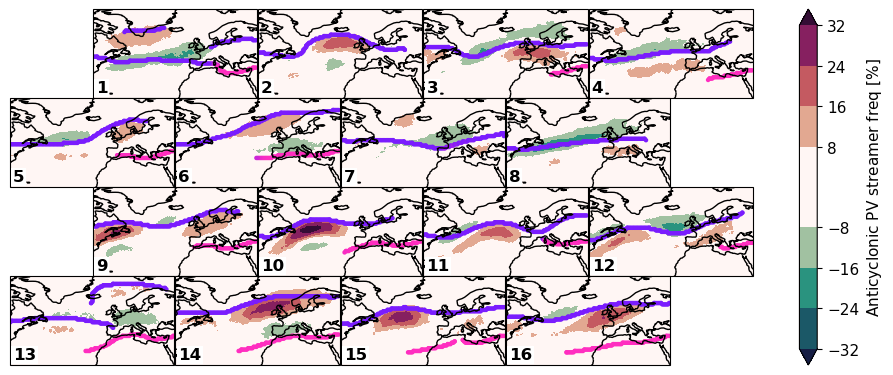

In [164]:
clu = Clusterplot(4, 4, honeycomb=True, region=get_region(da_apvs), numbering=True)
_ = clu.add_any_contour_from_mask(da_apvs * 100, mask_daily, cmap=colormaps.curl, levels=7, q=1-1e-3, cbar_label=long_names["apvs"])
axes = clu.axes.ravel()
for i in range(net.n_nodes):
    jets = all_jets_center_summer.filter(pl.col("cluster") == i)
    for j, jet in jets.group_by("jet ID", maintain_order=True):
        lo, la, is_p = jet[["lon", "lat", "is_polar"]].to_numpy().T
        axes[i].scatter(lo, la, c=is_p, lw=1, s=5, cmap=PINKPURPLE, vmin=0, vmax=1)
clu.fig.savefig(f"{FIGURES}/twostep_persistence/apvs.png")

In [126]:
apvs_masked = mask_from_spells_pl(spells, da_apvs)["apvs"]

In [127]:
apvs_masked_per_cluster = apvs_masked.groupby("value").mean("spell").rename({"value": "cluster"})
u_clu = apvs_masked_per_cluster.cluster.values.astype(np.int32)
to_zero = np.arange(net.n_nodes)[~np.isin(np.arange(net.n_nodes), u_clu)]
indexer = np.repeat(u_clu, np.diff(np.append(u_clu, [net.n_nodes])))
apvs_masked_per_cluster = apvs_masked_per_cluster.sel(cluster=indexer)
apvs_masked_per_cluster[to_zero, ...] = 0.
apvs_masked_per_cluster = apvs_masked_per_cluster.assign_coords(cluster=np.arange(net.n_nodes))

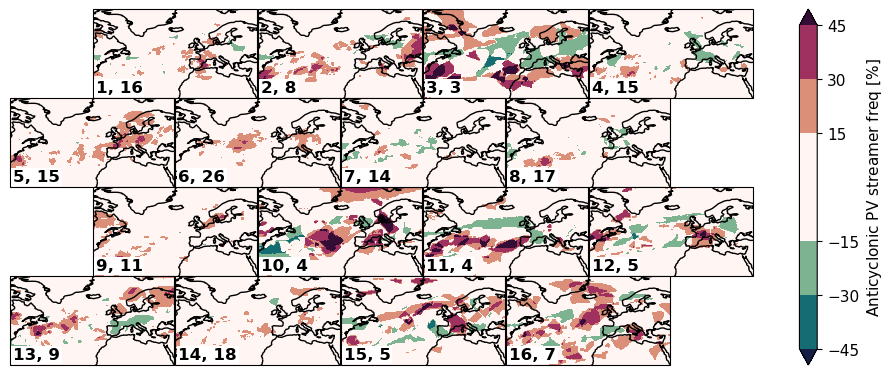

In [165]:
clu = Clusterplot(4, 4, honeycomb=True, region=get_region(apvs_masked_per_cluster), numbering=numbering)
_ = clu.add_contourf(apvs_masked_per_cluster.sel(relative_index=0) * 100, cmap=colormaps.curl, levels=7, q=1-1e-2, cbar_label=long_names["apvs"])
clu.fig.savefig(f"{FIGURES}/twostep_persistence/apvs_onset.png")

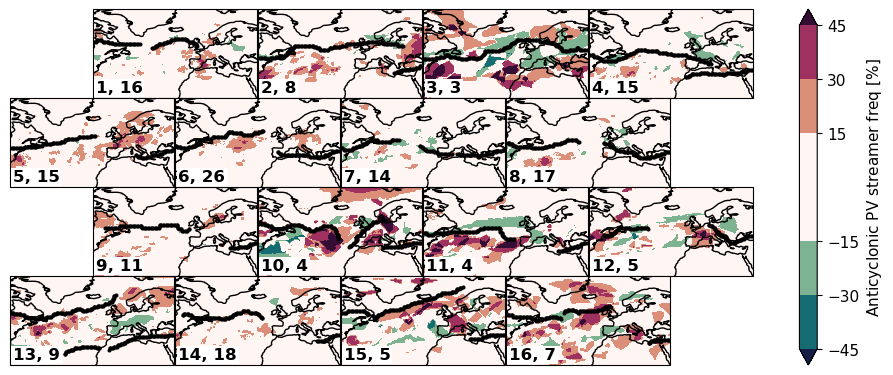

In [166]:
clu = Clusterplot(4, 4, honeycomb=True, region=get_region(apvs_masked_per_cluster), numbering=numbering)
_ = clu.add_contourf(apvs_masked_per_cluster.sel(relative_index=0) * 100, cmap=colormaps.curl, levels=7, q=1-1e-2, cbar_label=long_names["apvs"])
axes = clu.axes.ravel()
for i in range(net.n_nodes):
    jets = jets_masked.filter(pl.col("cluster") == i, pl.col("relative_index") == 0)
    for j, jet in jets.group_by("jet ID", maintain_order=True):
        lo, la = jet[["lon", "lat"]].to_numpy().T
        axes[i].scatter(lo, la, lw=1, s=15, c="black", marker=".")
clu.fig.savefig(f"{FIGURES}/twostep_persistence/apvs_onset_jets.png")

## cPVS

100%|██████████| 16/16 [00:00<00:00, 90.26it/s]


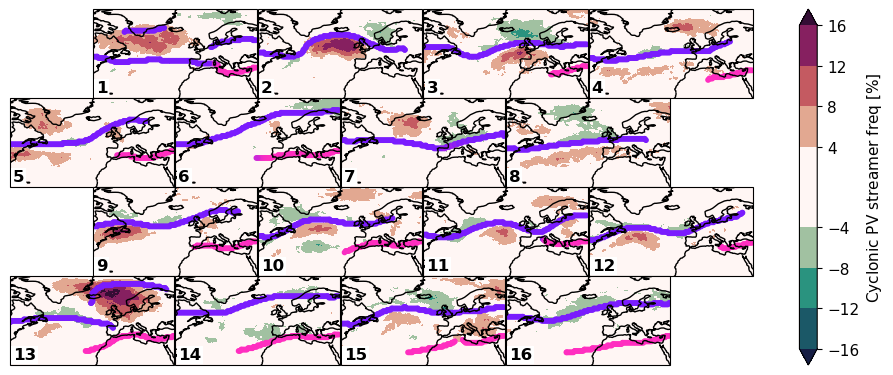

In [167]:
clu = Clusterplot(4, 4, honeycomb=True, region=get_region(da_cpvs), numbering=True)
_ = clu.add_any_contour_from_mask(da_cpvs * 100, mask_daily, cmap=colormaps.curl, levels=9, q=1-1e-3, cbar_label=long_names["cpvs"])
axes = clu.axes.ravel()
for i in range(net.n_nodes):
    jets = all_jets_center_summer.filter(pl.col("cluster") == i)
    for j, jet in jets.group_by("jet ID", maintain_order=True):
        lo, la, is_p = jet[["lon", "lat", "is_polar"]].to_numpy().T
        axes[i].scatter(lo, la, c=is_p, lw=1, s=10, cmap=PINKPURPLE, vmin=0, vmax=1)
clu.fig.savefig(f"{FIGURES}/twostep_persistence/cpvs.png")

In [132]:
cpvs_masked = mask_from_spells_pl(spells, da_cpvs)["cpvs"]

In [133]:
cpvs_masked_per_cluster = cpvs_masked.groupby("value").mean("spell").rename({"value": "cluster"})
u_clu = cpvs_masked_per_cluster.cluster.values.astype(np.int32)
to_zero = np.arange(net.n_nodes)[~np.isin(np.arange(net.n_nodes), u_clu)]
indexer = np.repeat(u_clu, np.diff(np.append(u_clu, [net.n_nodes])))
cpvs_masked_per_cluster = cpvs_masked_per_cluster.sel(cluster=indexer)
cpvs_masked_per_cluster[to_zero, ...] = 0.
cpvs_masked_per_cluster = cpvs_masked_per_cluster.assign_coords(cluster=np.arange(net.n_nodes))

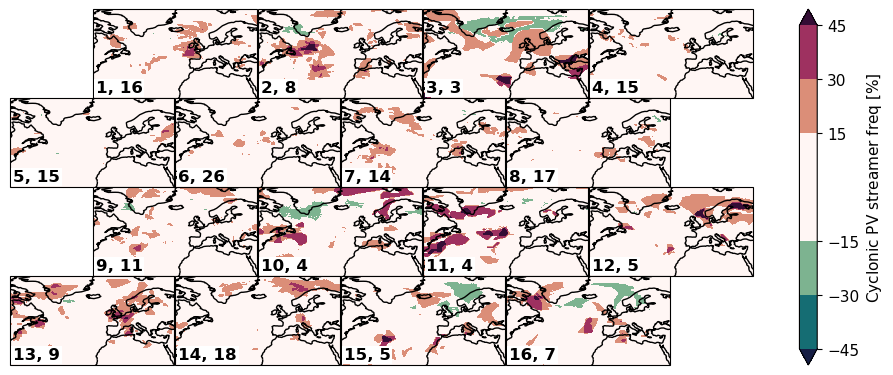

In [168]:
clu = Clusterplot(4, 4, honeycomb=True, region=get_region(cpvs_masked_per_cluster), numbering=numbering)
_ = clu.add_contourf(cpvs_masked_per_cluster.sel(relative_index=0) * 100, cmap=colormaps.curl, levels=7, q=1-1e-2, cbar_label=long_names["cpvs"])
clu.fig.savefig(f"{FIGURES}/twostep_persistence/cpvs_onset.png")

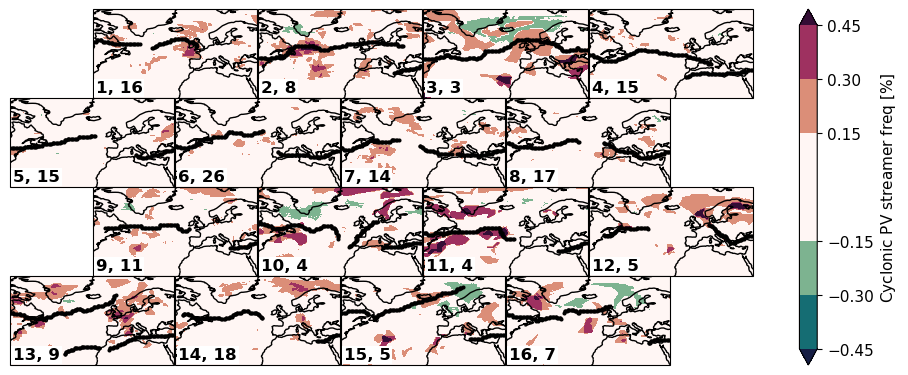

In [169]:
clu = Clusterplot(4, 4, honeycomb=True, region=get_region(cpvs_masked_per_cluster), numbering=numbering)
_ = clu.add_contourf(cpvs_masked_per_cluster.sel(relative_index=0), cmap=colormaps.curl, levels=7, q=1-1e-2, cbar_label=long_names["cpvs"])
axes = clu.axes.ravel()
for i in range(net.n_nodes):
    jets = jets_masked.filter(pl.col("cluster") == i, pl.col("relative_index") == 0)
    for j, jet in jets.group_by("jet ID", maintain_order=True):
        lo, la = jet[["lon", "lat"]].to_numpy().T
        axes[i].scatter(lo, la, lw=1, s=15, c="black", marker=".")
clu.fig.savefig(f"{FIGURES}/twostep_persistence/cpvs_onset_jets.png")